In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt

In [ ]:
device = "cpu" if not torch.cuda.is_available() else "cuda"

# adapter_model_id = "ahmedheakl/resume-classification-gemma-2b-v1" - another model we can use here (from the same paper)
adapter_model_id = "ahmedheakl/bert-resume-classification"

tokenizer = AutoTokenizer.from_pretrained(adapter_model_id, device=device)
model = AutoModelForSequenceClassification.from_pretrained(adapter_model_id)
model.eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def draw_attributions(attributions, input_ids, fig_number):
    token_attributions = attributions.sum(dim=-1).squeeze().detach().numpy()
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

    # Pair tokens with their attributions
    token_attr_pairs = list(zip(tokens, token_attributions))

    # Sort by absolute attribution value in descending order
    token_attr_pairs.sort(key=lambda x: abs(x[1]), reverse=True)

    # Select top 20
    top_20_pairs = token_attr_pairs[:20]

    # Unzip the top 20 pairs
    top_tokens, top_attributions = zip(*top_20_pairs)

    plt.figure(figsize=(14, 3))
    plt.bar(top_tokens, top_attributions)
    plt.xticks(rotation=45, ha="right") # Adjust rotation alignment
    plt.title("Top 20 Token Importance via Integrated Gradients")
    plt.tight_layout()

    plt.savefig(f"example{fig_number}.png", bbox_inches='tight')
    plt.show()



In [6]:
def test_sample(input_text, ig):
    input_ids = get_input_ids(input_text)
    baseline_ids = get_baseline_ids(input_ids)

    input_embeds = ids_to_embeddings(input_ids)
    baseline_embeds = ids_to_embeddings(baseline_ids)

    attributions, _ = ig.attribute(
        inputs=input_embeds,
        baselines=baseline_embeds,
        return_convergence_delta=True
    )

    return attributions, input_ids


def get_input_ids(input_text):
    inputs = tokenizer(input_text, return_tensors="pt", padding=True)
    return inputs["input_ids"]


def get_baseline_ids(reference_ids):
    inputs = tokenizer("", return_tensors="pt", padding="max_length", max_length=reference_ids.shape[1])
    return inputs["input_ids"]


def ids_to_embeddings(input_ids):
    return model.get_input_embeddings()(input_ids).requires_grad_(True)

In [7]:
def forward_from_embeddings(input_embeds):
    output = model(inputs_embeds=input_embeds)
    logits = output.logits
    return torch.softmax(logits, dim=1)[:, 1]

Senior Java developer with 10+ years experience in backend systems, cloud, and microservices.


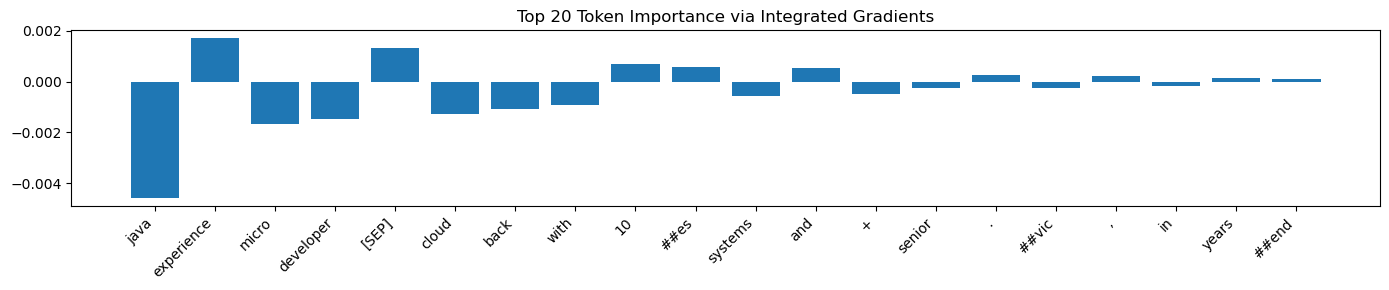

height 58 new york theatre girl called vincent cuff cautionary tail seven sicknesses restoration comedy tales 8th grade nobody scrooge goin south hint music man life comeback tour bonnie milligan 6143027969 bonniemilligangmailcom hair dark blonde eyes blue cora katemultiple roles york theatre 39hr reading entertainment events koren flea theatre nurse flea theatre hoyden flea theatre agnesmultiple roles exit pursued bear reading charwoman amy thelma ethel toffelmier jesus molly village light opera group scene ny international fringe festival village light opera group primary stages reading new york theatre experiment regional theatre bright room called day book days urinetown songs new world midsummer nights dream agnes god desdemona sound music girls got ta eat agnes ruth soupy sue woman 2 egeuspeaseblossom dr livingston desdemona maria b ohio state theatre oh curtain players oh gallery players oh club diversity theatre oh virginia arts festival va oh ny tour strollers theatre oh women

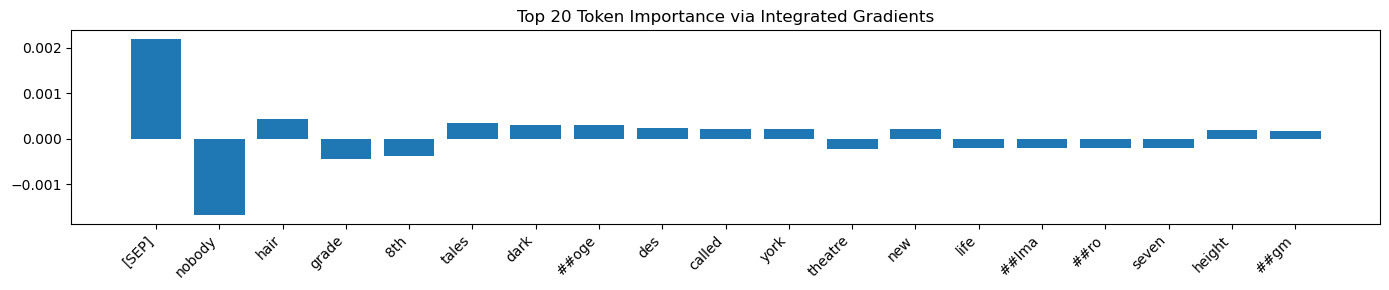

glaucia de souza lemos full stack net developer birth 10241986 gender female marital status single nationality brasilian career summary education specializations email glacia lemosyahoocombr phone 55 21 99152097232173973 technical website wwwcodecoderswordpresscom github linkedin aboutme lemos 3 years experience analysis design development clientserver webbased application expertise developing web applications microsoft visual studio using aspnet c sql server 20122014 hands experience debugging application using tools provided vs ability quickly grasp new technologies concepts consider full stack developer strong programming analytical interpersonal skills strong communication client interaction skills effective working independently mainly collaboratively agile teams associates degree 3 years system analysis development 022011122013 faculdades integradas de jacarepagu specialization course webdeveloper c net coti inform tica julyseptember 2013 main frameworks c language study includes

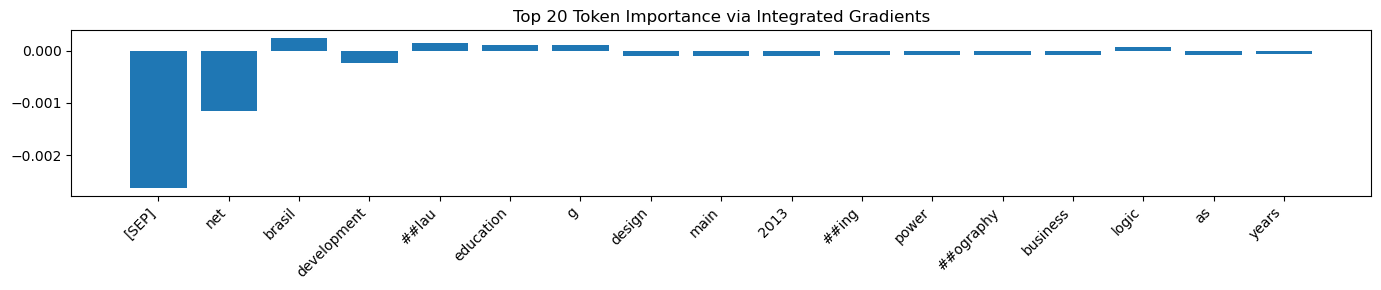

simran preet grewal female email simrangrewalgmailcom 919953363632 year degree pursuin bschons agriculture g 2014 xiicbse 2012 xcbse academic qualifications institute lovely professional university phagwara dav public school bhilai dav public school bhilai lovely professional university cgpa percentage 85210 70 9010 projectsinternship syngenta india limited haryana jun 2017july 2017 cotton crops product development undergone 45 days training researched extensively problems farmers faced interacted dealers retailers farmers use pesticides cotton crop marketed products company helped crops grow better result users product asked experience report written presented board area interest artificial hybridization air layering positions responsibility student placement coordinator lovely professional university 2018 coordinator club mridalovely professional university 2018 extra curricular activities workshops seminar conferences achievemen ts participatio n participated conference sustainable 

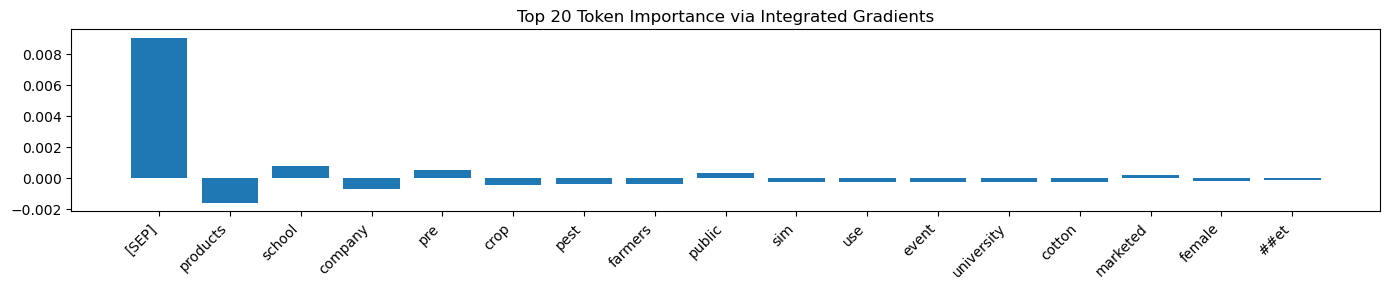

In [12]:
gender_marked_texts = [
    "Senior Java developer with 10+ years experience in backend systems, cloud, and microservices.", # small test text
    "height 58 new york theatre girl called vincent cuff cautionary tail seven sicknesses restoration comedy tales 8th grade nobody scrooge goin south hint music man life comeback tour bonnie milligan 6143027969 bonniemilligangmailcom hair dark blonde eyes blue cora katemultiple roles york theatre 39hr reading entertainment events koren flea theatre nurse flea theatre hoyden flea theatre agnesmultiple roles exit pursued bear reading charwoman amy thelma ethel toffelmier jesus molly village light opera group scene ny international fringe festival village light opera group primary stages reading new york theatre experiment regional theatre bright room called day book days urinetown songs new world midsummer nights dream agnes god desdemona sound music girls got ta eat agnes ruth soupy sue woman 2 egeuspeaseblossom dr livingston desdemona maria b ohio state theatre oh curtain players oh gallery players oh club diversity theatre oh virginia arts festival va oh ny tour strollers theatre oh womens explosive theatre oh archbold players oh club diversity theatre oh 2012 drama desk nominee best direction play dir ed sylvanus iskandar 2013 drama desk nominee best direction play dir ed sylvanus iskandar concerts upon time new york city soloist adam gwon 54 educationtraining joes pub soloistensemble 54 ba theatre honors distinction ohio state university magna cum laude osu trainingmeisner stanislavski acting techniques kristin linklater voice lessac movement advanced viewpoints suzuki movement advanced dialects edith skinner ipa training basic moderntapmusical theatre dance theatre du complicite londonactingmovement improbable theatre londonactingimprovisation shared experience londonacting upright citizens brigadeimprovisation shakespearelan hersey linklater voice techniqueelena mcghee special skills mezzobelter gospel singing celine dion singing impersonation basic piano standard british cockney irish french southern midwestern accents advanced primary source dialect analysis passport good children animals boob flexing squirrel noises",
    "glaucia de souza lemos full stack net developer birth 10241986 gender female marital status single nationality brasilian career summary education specializations email glacia lemosyahoocombr phone 55 21 99152097232173973 technical website wwwcodecoderswordpresscom github linkedin aboutme lemos 3 years experience analysis design development clientserver webbased application expertise developing web applications microsoft visual studio using aspnet c sql server 20122014 hands experience debugging application using tools provided vs ability quickly grasp new technologies concepts consider full stack developer strong programming analytical interpersonal skills strong communication client interaction skills effective working independently mainly collaboratively agile teams associates degree 3 years system analysis development 022011122013 faculdades integradas de jacarepagu specialization course webdeveloper c net coti inform tica julyseptember 2013 main frameworks c language study includes application development web cnet design patterns aspnet codebehind mvc contents c oop dal bll business logic layer ajax net cryptography aspnet md5 symmetrickey cryptography entity framework linq nhibernate crystal reports aspnet mvc2 mvc3 e mvc4 web applications tdd net spring net oracle html5 specialization course aspnet mvc 5 enterprise applications eduardo pires february2016 targetting learn main new features order develop large corporate systems resposibilities levels based architecting applications real world net aiming promote better performance well security system maintenance contents mvc pattern pipeline aspnet mvc 5 controllers views models forms e html helpers routes managing scripts javascript css data annotations validation javascript ajax scaffolding security viewmodels e automapper entity framework tdd cdn cache performance techniques aspnet mvc filten aspnet identity aspnet web api architecture ddd oop solid etc deploy azure objectoriented programming fundamentals cpluralsight 082015 building applications aspnet mvc 4pluralsight 092015 introduction net testing nunitpluralsight 112015 introduction nodejspluralsight 112015 code metricsgloballogic latam methodology scrumagilegloballogic latam shaping angularjscodeschool 052016 accelerating angular 2codeschool 072016 become full stacknet developerfundamentalspluralsight062016 powering reactcodeschool092016",
    "simran preet grewal female email simrangrewalgmailcom 919953363632 year degree pursuin bschons agriculture g 2014 xiicbse 2012 xcbse academic qualifications institute lovely professional university phagwara dav public school bhilai dav public school bhilai lovely professional university cgpa percentage 85210 70 9010 projectsinternship syngenta india limited haryana jun 2017july 2017 cotton crops product development undergone 45 days training researched extensively problems farmers faced interacted dealers retailers farmers use pesticides cotton crop marketed products company helped crops grow better result users product asked experience report written presented board area interest artificial hybridization air layering positions responsibility student placement coordinator lovely professional university 2018 coordinator club mridalovely professional university 2018 extra curricular activities workshops seminar conferences achievemen ts participatio n participated conference sustainable agriculture food nutrition 2018 aegis lovely professional university participated art theatre workshop organized division student welfare lovely professional university awarded 1 prize category flower ornaments spring flower show school agriculture lovely professional university awarded 2nd prize event agrichamps 2018 organized school professional enhancement iii lovely professional university participated indian agriculture fair 2018 held rajasthan language proficiency english hindi telugu punjabi personal details"
]

ig = IntegratedGradients(forward_from_embeddings)

for i, text in enumerate(gender_marked_texts):
    print(text)
    attributions, input_ids = test_sample(text, ig)
    draw_attributions(attributions, input_ids, i)
